<a href="https://colab.research.google.com/github/GustavoDenobi/AIMic/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network modelling and training

This notebook comprises the development of Convolutional Neural Networks intended to be used to classify audio. The generation of the dataset used here was done separately and can't be made public, for protection of the original voice contributions.

## Imports

The following cell performs most of the imports in this notebook, and also defines `strategy` for use during training.

In [0]:
import os
import sys
import random
import numpy as np
import pandas as pd
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import IPython
from google.colab import output
import time
import csv
!pip install 'librosa==0.7.2'
import librosa as lib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras import regularizers
from tensorflow.distribute import Strategy, MirroredStrategy
from tensorflow.distribute.experimental import TPUStrategy, MultiWorkerMirroredStrategy
import math
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

## Miscelaneous

### Google Drive storage
If you want to download info generated in this notebook, like neural networks checkpoints, do the following in the next cells:
- Define `gdrive_path`, the path in your Google Drive where files should be stored.
- Run the cell and follow the authorization steps.

In [0]:
from google.colab import drive
import os
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
gdrive_path = "Eng Mecatrônica/5o Ano/TCC/"
work_path = os.path.join("/content/drive/My Drive", gdrive_path)

### Importing the dataset

In [0]:
# SP2ALL 4:1
!gdown https://drive.google.com/uc?id=14MvhRaU8CUrGM8U3GRingeEwtygjequk

!unzip -q GENERATED.zip
!rm GENERATED

Downloading...
From: https://drive.google.com/uc?id=14MvhRaU8CUrGM8U3GRingeEwtygjequk
To: /content/GENERATED.zip
16.4GB [06:22, 42.8MB/s]
rm: cannot remove 'GENERATED': Is a directory


In [0]:
!rm GENERATED/000028-000.wav

## Data management classes

Following, there are 3 classes, designed to work together as an interface between the dataset and the neural networks.

- `AudioHandler` deals with audio file reading and the spectrogram;
- `DataSequence` extends the `Sequence` class, and is use to provide training samples to the networks on demand, instead of buffering the whole dataset at once;
- `DatasetHandler` wraps both previous classes, deals with initialization and validation data buffering;

In [0]:
class AudioHandler(object):
    def __init__(self, dataset_dir, sr = 22050):
        self.dataset_dir = dataset_dir
        self.sr = sr
        print('Audio Handler initialized.')

    def spectrogram_deprecated(self, samples, sample_rate = 22050, stride_ms = 10.0, window_ms = 20.0, max_freq = None, eps = 1e-14):
        
        stride_size = int(0.001 * sample_rate * stride_ms)
        window_size = int(0.001 * sample_rate * window_ms)

        # Extract strided windows
        truncate_size = (len(samples) - window_size) % stride_size
        samples = samples[:len(samples) - truncate_size]
        nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
        nstrides = (samples.strides[0], samples.strides[0] * stride_size)
        windows = np.lib.stride_tricks.as_strided(samples, 
                                            shape = nshape, strides = nstrides)
        
        assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

        # Window weighting, squared Fast Fourier Transform (fft), scaling
        weighting = np.hanning(window_size)[:, None]
        
        fft = np.fft.rfft(windows * weighting, axis=0)
        fft = np.absolute(fft)
        fft = fft**2
        
        scale = np.sum(weighting**2) * sample_rate
        fft[1:-1, :] *= (2.0 / scale)
        fft[(0, -1), :] /= scale
        
        # Prepare fft frequency list
        freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
        
        # Compute spectrogram feature
        max_freq = sample_rate/2
        ind = np.where(freqs <= max_freq)[0][-1] + 1
        specgram = np.log(fft[:ind, :] + eps)
        return specgram

    def spectrogram(self, samples, sample_rate = 22050):
        return lib.feature.melspectrogram(samples, sr=sample_rate)

    def get_sample(self, filename):
        try:
            filepath = os.path.join(self.dataset_dir, filename)
            sample_rate, samples = wavfile.read(filepath)
            specgram = self.spectrogram(samples)
            return specgram
        except ValueError:
            print(filename)

    def get_raw_audio(self, filename, sr=22050):
        filepath = os.path.join(self.dataset_dir, filename)
        sample_rate, samples = wavfile.read(filepath)
        self.show_audio_player(samples)

    def show_audio_player(self, filename):
        IPython.display.display(Audio(filename))

In [0]:
class DataSequence(Sequence):

    def __init__(self, filelist, batch_size, x_sel, y_sel):
        self.dataset_dir = "/content/GENERATED"
        self.audio = AudioHandler(self.dataset_dir)
        self.batch_size = batch_size
        self.x = self.get_input(filelist, x_sel)
        self.y = self.get_labels(self.x, y_sel)
        print('DataSequence initialized.')

    def get_input(self, filelist, select):
        if select == 'all':
            return filelist
        else:
            x = []
            for f in filelist:
                sample = f.split('-')[1].split('.')[0]
                has_speech = True if sample[0] == '1' else False
                has_multi = True if sample[1] == '1' else False
                has_activation = True if sample[2] == '1' else False
                if select == 'speech' and has_speech:
                    x.append(f)
                if select == 'multivoice' and has_multi:
                    x.append(f)
                if select == 'activation' and has_activation:
                    x.append(f)
            return x

    def get_labels(self, filelist, select):
        y = []
        for sample in filelist:
            sample = sample.split('-')[1].split('.')[0]
            has_speech = 1 if sample[0] == '1' else 0
            has_multi = 1 if sample[1] == '1' else 0
            has_activation = 1 if sample[2] == '1' else 0
            if select == 'speech':
                y.append(has_speech)
            if select == 'multivoice':
                y.append(has_multi)
            if select == 'activation':
                y.append(has_activation)
        return y

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            np.expand_dims(self.audio.get_sample(file_name), axis=2)
                for file_name in batch_x]), np.array(batch_y)

In [0]:
class DatasetHandler(object):
    def __init__(self, batch_size = 32, test_proportion = 0.1, x_sel = 'all', y_sel = 'speech'):
        assert(x_sel in ['all', 'speech'])
        assert(y_sel in ['speech', 'multivoice', 'activation'])
        assert(x_sel != y_sel)
        self.dataset_dir = "/content/GENERATED"
        self.audio = AudioHandler(self.dataset_dir)
        self.samples = self.get_sets(test_proportion)
        self.train_seq = DataSequence(self.samples['train'], batch_size, x_sel, y_sel)
        self.test_set = self.buffer_files(self.samples['test'], x_sel, y_sel)
        print('DatasetHandler initialized.')

    def get_sets(self, test_proportion):
        train = os.listdir(self.dataset_dir)
        train.sort()
        test = []
        for i in range(int(len(train)*test_proportion)):
            test.append(train.pop(i))
        return {'train': train, 'test': test}

    def buffer_files(self, files, x_sel, y_sel):
        x = []
        y = []
        for f in files:
            sample = f.split('-')[1].split('.')[0]
            has_speech = 1 if sample[0] == '1' else 0
            has_multi = 1 if sample[1] == '1' else 0
            has_activation = 1 if sample[2] == '1' else 0
            if x_sel == 'all':
                x.append(np.expand_dims(self.audio.get_sample(f), axis=2))
                if y_sel == 'speech':
                    y.append(has_speech)
                elif y_sel == 'multivoice':
                    y.append(has_multi)
                elif y_sel == 'activation':
                    y.append(has_activation)
            elif x_sel == 'speech' and has_speech == 1:
                x.append(np.expand_dims(self.audio.get_sample(f), axis=2))
                if y_sel == 'speech':
                    y.append(has_speech)
                elif y_sel == 'multivoice':
                    y.append(has_multi)
                elif y_sel == 'activation':
                    y.append(has_activation)
        return np.array(x), np.array(y)

    def get_sample_from_test(self, index):
        if index < 0 or index > len(self.samples['train']):
            return False
        sample = self.samples['train'][index].split('-')[1].split('.')[0]
        has_speech = 1 if sample[0] == '1' else 0
        has_multi = 1 if sample[1] == '1' else 0
        has_activation = 1 if sample[2] == '1' else 0
        y = 0
        if y_sel == 'speech':
            y = has_speech
        elif y_sel == 'multivoice':
            y = has_multi
        elif y_sel == 'activation':
            y = has_activation
        return self.test_set[index], y

## Models

Each `define_model` function defines a different configuration of CNN, compiles the model and returns it. Notice that the model is only created when the function is executed.

### Phase 1

These were the first models tested. Those are very small CNNs, and although they seem to perform well, they don't. Even those that hit over 90% accuracy on test set are still not working with real world data. The dataset used here had 20K samples.

In [0]:
# 0.83 @ 18 epochs, than overfits

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0.82 @ 23 epochs, than overfits

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0.82 @ 23 epochs, than overfits

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.000025, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,87 acc for activation against all

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(86, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,86 on speech against all @ 13 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(48, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,84 on act against speech @ 20 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,86 on act against speech @ 22 epochs
# 0,86 on sp against all @ 39 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,85 in act against speech @ 25 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,85 in act against speech @ 37 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,86 in act against speech @ 24 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(48, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 0,88 in speech against all @ 22 epochs

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# 12
weights_sp2all = "weights-0.905@23-model#12-sp2all.hdf5"
weights_act2sp = "weights-0.868@20-model#12-act2sp.hdf5"

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
weights_sp2all = "weights-0.908@24-model#13-sp2all.hdf5"

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
weights_sp2all = "weights-0.881@17-model#14-sp2all.hdf5"
weights_act2sp = "weights-0.870@18-model#14-act2sp.hdf5"
from tensorflow.keras.layers import LeakyReLU

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#15
from tensorflow.keras.layers import LeakyReLU

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3))
    model.add(LeakyReLU())
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3))
    model.add(LeakyReLU())
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#16
from tensorflow.keras.layers import LeakyReLU

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3))
    model.add(LeakyReLU())
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3))
    model.add(LeakyReLU())
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#17

def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#18
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='softplus'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#19
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='softplus', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='softplus'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='softplus'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#20
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#21
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#18
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(72, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(54, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(36, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='softplus'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

### Phase 2

Phase 2 began with some changes to training parameters, some different tests and a bigger dataset, with 40K samples. Accuracy did not improve, and testing the new models also proved they are still not able to recognize samples.

In [0]:
#1
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#2
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#3
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=11, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=11, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=11, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
#4
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=7, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=7, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=7, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

### Phase 3

To solve some of the possible problems in the first 2 phases, I'm now trying to add complexity to the models. Also generated a new dataset, with a ratio of 4:1 noise to speech, since it seems logical that the variety of noises the model has to recognize is a lot bigger than the one of voices. Also, the current dataset has +72K samples.

In [0]:
model_number = 1
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    #model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    #model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
model_number = 2
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    #model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    #model.add(MaxPool2D())
    model.add(Conv2D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
model_number = 3
def define_model(input_shape = (221,199,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv2D(128, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(192, kernel_size=5, activation='relu'))
    model.add(Conv2D(192, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(128, kernel_size=5, activation='relu'))
    model.add(Conv2D(128, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(512, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='softplus'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

### Phase 4
The big change here is in the data presented to the model, which has changed from a linear spectrogram with dimensions (221, 199, 1) to a mel spectrogram with dimensions (128, 87, 1). The mel representation should expose the relevant features of a sample more easily.

In [0]:
model_number = 1
def define_model(input_shape = (128,87,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(Conv2D(48, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
model_number = 2
def define_model(input_shape = (128,87,1)):
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, activation='relu'))
    model.add(Conv2D(48, kernel_size=5, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(256, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='softplus'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    adam = keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Training

The `train` function runs the `model` on the `dataset` for n `epochs`, using callbacks for early stopping if and when the model starts overfitting, with a delay defined in `patience` as the number the epochs waits until stopping the training, and another callback to checkpoint the best weights.

In [0]:
def train(model, dataset, model_name, epochs=20, patience=3):
    callbacks_list = []
    # patience
    if patience > 0:
        #es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
        #callbacks_list.append(es_callback)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=patience, min_lr=0.00000001, cooldown=5)
        callbacks_list.append(reduce_lr)
    # checkpoint
    checkpoint_dir = 'content/'
    try:
        checkpoint_dir = work_path
    except NameError:
        print('Storing checkpoint values locally.')
    filepath=os.path.join(checkpoint_dir, "model#" + str(model_name) + "-acc{val_accuracy:.3f}-loss{val_loss:.3f}@{epoch:02d}.hdf5")
    #filepath=os.path.join(checkpoint_dir, "weights-improvement-{val_accuracy:.2f}.hdf5")
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
    
    callbacks_list.append(checkpoint)
    # training
    history = model.fit(dataset.train_seq, validation_data=dataset.test_set, epochs=epochs, callbacks=callbacks_list)

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return history

In [0]:
history = []
with strategy.scope():
    data = DatasetHandler(batch_size = 32)
    model = define_model(input_shape = (128,87,1))
    history = train(model, data, model_number, epochs=25)

Audio Handler initialized.
Audio Handler initialized.
DataSequence initialized.
DatasetHandler initialized.
Epoch 1/25
2040/2040 [==============================] - 773s 379ms/step - loss: 0.4993 - accuracy: 0.8019 - val_loss: 0.4799 - val_accuracy: 0.8060 - lr: 1.0000e-05
Epoch 2/25
2040/2040 [==============================] - 777s 381ms/step - loss: 0.4816 - accuracy: 0.8018 - val_loss: 0.4508 - val_accuracy: 0.8116 - lr: 1.0000e-05
Epoch 3/25
2040/2040 [==============================] - 773s 379ms/step - loss: 0.4607 - accuracy: 0.8064 - val_loss: 0.4246 - val_accuracy: 0.8233 - lr: 1.0000e-05
Epoch 4/25
2040/2040 [==============================] - 778s 382ms/step - loss: 0.4447 - accuracy: 0.8096 - val_loss: 0.4042 - val_accuracy: 0.8257 - lr: 1.0000e-05
Epoch 5/25
2040/2040 [==============================] - 778s 381ms/step - loss: 0.4199 - accuracy: 0.8207 - val_loss: 0.3788 - val_accuracy: 0.8493 - lr: 1.0000e-05
Epoch 6/25
2040/2040 [==============================] - 773s 379ms/

In [0]:
history = []
with strategy.scope():
    data = DatasetHandler(batch_size = 64)
    model = define_model()
    model.load_weights("/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/model#1-acc0.944-loss0.169@08.hdf5")
    history = train(model, data, model_number, epochs=10)

Audio Handler initialized.
Audio Handler initialized.
DataSequence initialized.
DatasetHandler initialized.
Epoch 1/10
1407/1407 [==============================] - 1052s 748ms/step - loss: 0.1522 - accuracy: 0.9449 - val_loss: 0.1491 - val_accuracy: 0.9496 - lr: 1.0000e-05
Epoch 2/10
1407/1407 [==============================] - 1041s 740ms/step - loss: 0.1470 - accuracy: 0.9476 - val_loss: 0.1506 - val_accuracy: 0.9476 - lr: 1.0000e-05
Epoch 3/10
1407/1407 [==============================] - 1039s 739ms/step - loss: 0.1438 - accuracy: 0.9486 - val_loss: 0.1484 - val_accuracy: 0.9492 - lr: 1.0000e-05
Epoch 4/10
1407/1407 [==============================] - 1029s 732ms/step - loss: 0.1412 - accuracy: 0.9491 - val_loss: 0.1578 - val_accuracy: 0.9428 - lr: 1.0000e-05
Epoch 5/10
1407/1407 [==============================] - 1031s 733ms/step - loss: 0.1402 - accuracy: 0.9502 - val_loss: 0.1434 - val_accuracy: 0.9521 - lr: 1.0000e-05
Epoch 6/10
1407/1407 [==============================] - 1029s 

Audio Handler initialized.
Audio Handler initialized.
DataSequence initialized.
DatasetHandler initialized.
Epoch 1/20
4501/4501 [==============================] - 212s 47ms/step - loss: 0.0109 - accuracy: 0.9866 - val_loss: 0.0630 - val_accuracy: 0.9265 - lr: 1.0000e-05
Epoch 2/20
4501/4501 [==============================] - 201s 45ms/step - loss: 0.0089 - accuracy: 0.9884 - val_loss: 0.0623 - val_accuracy: 0.9277 - lr: 1.0000e-05
Epoch 3/20
4501/4501 [==============================] - 186s 41ms/step - loss: 0.0080 - accuracy: 0.9893 - val_loss: 0.0593 - val_accuracy: 0.9323 - lr: 1.0000e-05
Epoch 4/20
4501/4501 [==============================] - 185s 41ms/step - loss: 0.0076 - accuracy: 0.9902 - val_loss: 0.0603 - val_accuracy: 0.9293 - lr: 1.0000e-05
Epoch 5/20
4501/4501 [==============================] - 184s 41ms/step - loss: 0.0084 - accuracy: 0.9885 - val_loss: 0.0605 - val_accuracy: 0.9290 - lr: 1.0000e-05
Epoch 6/20
4501/4501 [==============================] - 184s 41ms/step -

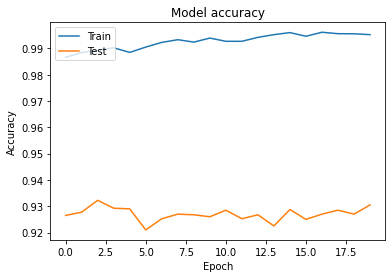

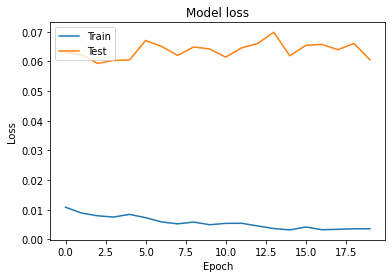

In [0]:
with strategy.scope():
    data = DatasetHandler(batch_size = 8)
    model = define_model()
    model.load_weights("/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/weights-model#18-sp2all-0.934@14.hdf5")
    history = train(model, data, 'model#18-sp2all', epochs=20)

In [0]:
with strategy.scope():
    data = DatasetHandler(batch_size = 32, x_sel = 'speech', y_sel='activation')
    model = define_model()
    history = train(model, data, 'model#19-act2sp', epochs=75)

In [0]:
with strategy.scope():
    data = DatasetHandler(batch_size = 128)
    model = define_model()
    history = train(model, data, 'model#17-sp2all', epochs=75)

In [0]:
with strategy.scope():
    data = DatasetHandler(batch_size = 128, x_sel = 'speech', y_sel='activation')
    model = define_model()
    history = train(model, data, 'model#17-act2sp', epochs=75)

## Validation

In [0]:
def load_weights(model, path_to_weights):
    return model.load_weights(path_to_weights)

In [0]:
model = define_model()
model.load_weights("/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/model#1-acc0.935-loss0.197@13.hdf5")
data = DatasetHandler(x_sel = 'all', y_sel='speech')
misclassified = []
print('Processing {} samples. Please wait...'.format(len(data.test_set[0])))
for i in range(len(data.test_set[0])):
    x = np.expand_dims(data.test_set[0][i], axis=0)
    y = data.test_set[1][i]
    y_pred = round(model.predict(x)[0][0])
    if y != y_pred:
        misclassified.append(data.samples['test'][i])
print('Done.')

ValueError: ignored

In [0]:
#audio = AudioHandler("/content/GENERATED")
#print(misclassified[:10])
false_negative = []
false_positive = []
y_sel = 'speech'
for filename in misclassified:
    sample = filename.split('-')[1].split('.')[0]
    has_speech = True if sample[0] == '1' else False
    has_multi = True if sample[1] == '1' else False
    has_activation = True if sample[2] == '1' else False
    if y_sel == 'speech':
        if has_speech:
            false_negative.append(filename)
        else:
            false_positive.append(filename)
    elif y_sel == 'multivoice':
        if has_multi:
            false_negative.append(filename)
        else:
            false_positive.append(filename)
        y = has_multi
    elif y_sel == 'activation':
        if has_activation:
            false_negative.append(filename)
        else:
            false_positive.append(filename)

In [0]:
print('False negative: ', str(len(false_negative)))
for sample in false_negative[0:10]:
    print(sample)
    sample_rate, samples = wavfile.read(os.path.join('/content/GENERATED', sample))
    IPython.display.display(Audio(samples, rate=sample_rate))
print('False positive: ', str(len(false_positive)))
for sample in false_positive[0:10]:
    print(sample)
    sample_rate, samples = wavfile.read(os.path.join('/content/GENERATED', sample))
    IPython.display.display(Audio(samples, rate=sample_rate))

In [0]:
print(len(os.listdir('/content/GENERATED')))

100010


In [0]:
print('gfsdasdf'[-4:])

asdf


In [0]:
data = DatasetHandler()

Audio Handler initialized.
Audio Handler initialized.
DataSequence initialized.


KeyboardInterrupt: ignored